In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
# Parameters
n_series = 10                # Number of time series
n_time = 500                 # Number of data points per series
n_train = int(0.8 * n_time)  # 80% for training (400)
n_test = n_time - n_train    # 20% for testing (100)
n_lags = 3                   # Number of lagged observations
n_components = 8             # Number of latent features via SVD
n_splits = 3                 # Number of cross-validation splits

# Generate datetime index
start_date = '2020-01-01'
freq = 'D'  # Daily frequency
dates = pd.date_range(start=start_date, periods=n_time, freq=freq)

In [3]:
def generate_time_series(n_points, trend=0.0, seasonality_period=50, seasonality_amplitude=1.0, noise_level=0.1, base=10.0):
    """Generates a synthetic time series with trend, seasonality, and noise, ensuring all values >0 by adding a base offset."""
    trend_component = trend * np.arange(n_points)
    seasonal_component = seasonality_amplitude * np.sin(2 * np.pi * np.arange(n_points) / seasonality_period)
    noise_component = np.random.normal(0, noise_level, n_points)
    random_walk = np.cumsum(noise_component)  # Random walk
    series = trend_component + seasonal_component + noise_component + base  # Adding base to ensure positivity
    return series

In [4]:
# Generate 10 unique time series
time_series_data = {}
for i in range(n_series):
    # Assign unique parameters for each series
    trend = np.random.uniform(-0.05, 0.05)  # Random trend between -0.05 and 0.05
    seasonality_period = np.random.choice([50, 100, 200])  # Different seasonality periods
    seasonality_amplitude = np.random.uniform(0.5, 2.0)  # Different amplitudes
    noise_level = np.random.uniform(0.5, 1.5)  # Different noise levels
    base = 50.0  # Ensuring all values >0

    # Generate the series
    series = generate_time_series(
        n_points=n_time,
        trend=trend,
        seasonality_period=seasonality_period,
        seasonality_amplitude=seasonality_amplitude,
        noise_level=noise_level,
        base=base
    )

    # Store in dictionary
    time_series_data[f'Series_{i+1}'] = series

In [5]:
# Convert to DataFrame
df = pd.DataFrame(time_series_data, index=dates)
print("Generated Time Series Data:")
display(df.head())

Generated Time Series Data:


,Series_1,Series_2,Series_3,Series_4,Series_5,Series_6,Series_7,Series_8,Series_9,Series_10
2020-01-01,48.467178,52.243640,50.106227,49.446488,49.732942,48.600890,50.081188,51.049444,50.758590,50.531690
2020-01-02,52.825267,50.375406,49.125299,50.383708,49.026182,48.621291,50.298030,48.427633,50.331814,51.002955
2020-01-03,50.046595,50.618633,50.203581,51.915372,48.994577,50.480493,49.691484,48.953568,49.773318,50.180005
2020-01-04,49.059102,49.182584,50.140144,52.565042,51.389559,50.538865,50.667050,50.298236,49.100624,50.395968
2020-01-05,49.190427,50.821542,50.127642,52.805888,50.856757,50.531072,50.469072,52.434929,51.000405,51.212558


In [6]:
# Check for NaN values
assert not df.isnull().values.any(), "Data contains NaN values!"

In [7]:
# Check data shape
expected_shape = (n_time, n_series)
assert df.shape == expected_shape, f"Data shape mismatch! Expected {expected_shape}, got {df.shape}"
print(f"Data Shape Correct: {df.shape}")

# Ensure all values are >0
assert (df.values > 0).all(), "Some data points are <= 0!"
print("\nAll data points are greater than 0.")

Data Shape Correct: (500, 10)

All data points are greater than 0.


In [8]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to generate lagged features and datetime-based features.
    """
    def __init__(self, n_lags=3, verbose=False):
        self.n_lags = n_lags
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Generate lagged and datetime-based features for each series.

        Parameters:
        - X: DataFrame, shape (n_time, n_series)

        Returns:
        - X_transformed: DataFrame, shape (n_samples, n_lags + n_time_features)
        """
        features = []
        for series in X.columns:
            for t in range(self.n_lags, len(X)):
                lag = X[series].iloc[t - self.n_lags:t].values
                date = X.index[t]
                month = date.month
                day = date.day
                day_of_week = date.dayofweek  # Monday=0, Sunday=6
                is_weekend = 1 if day_of_week >=5 else 0
                quarter = date.quarter
                features.append(list(lag) + [month, day, day_of_week, is_weekend, quarter])

        feature_names = [f'lag_{i+1}' for i in range(self.n_lags)] + ['month', 'day', 'day_of_week', 'is_weekend', 'quarter']
        X_transformed = pd.DataFrame(features, columns=feature_names)

        # Validation check: Feature engineering
        expected_samples = (n_time - self.n_lags) * n_series
        assert X_transformed.shape[0] == expected_samples, \
            f"Feature matrix shape mismatch! Expected {expected_samples}, got {X_transformed.shape[0]}"
        assert len(X_transformed.columns) == self.n_lags + 5, \
            f"Number of features mismatch! Expected {self.n_lags + 5}, got {len(X_transformed.columns)}"

        if self.verbose:
            print("Feature Engineering Completed:")
            display(X_transformed.head())
            print("\n")

        return X_transformed

In [9]:
class LatentFeatureGenerator(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to generate latent features using Truncated SVD.
    """
    def __init__(self, n_components=8, verbose=False):
        self.n_components = n_components
        self.scaler = StandardScaler()
        self.svd = TruncatedSVD(n_components=self.n_components, random_state=42)
        self.verbose = verbose

    def fit(self, X, y=None):
        """
        Fit StandardScaler and Truncated SVD on the feature matrix.
        """
        # Scaling
        self.scaler.fit(X)
        X_scaled = self.scaler.transform(X)

        # Matrix factorization
        self.svd.fit(X_scaled)
        return self

    def transform(self, X):
        """
        Transform the feature matrix to include latent features.

        Parameters:
        - X: DataFrame, shape (n_samples, n_features)

        Returns:
        - X_with_latent: DataFrame, shape (n_samples, n_features + n_components)
        """
        # Scaling
        X_scaled = self.scaler.transform(X)

        # Matrix factorization
        latent_features = self.svd.transform(X_scaled)

        # Create DataFrame for latent features
        latent_df = pd.DataFrame(latent_features, columns=[f'latent_{i+1}' for i in range(self.n_components)], index=X.index)

        # Combine original and latent features
        X_with_latent = pd.concat([pd.DataFrame(X.values, columns=X.columns), latent_df], axis=1)

        # Validation check: Latent feature generation
        expected_columns = len(X.columns) + self.n_components
        assert X_with_latent.shape[1] == expected_columns, \
            f"Latent feature generation failed! Expected {expected_columns} columns, got {X_with_latent.shape[1]}"

        if self.verbose:
            print("Latent Feature Generation Completed:")
            display(X_with_latent.head())
            print("\n")

        return X_with_latent

In [10]:
# Initialize feature engineering objects
feature_engineer = FeatureEngineer(n_lags=n_lags, verbose=True)
latent_feature_gen = LatentFeatureGenerator(n_components=n_components, verbose=True)

# Apply feature engineering
X_features = feature_engineer.fit_transform(df)
X_with_latent = latent_feature_gen.fit_transform(X_features)

Feature Engineering Completed:


,lag_1,lag_2,lag_3,month,day,day_of_week,is_weekend,quarter
0,48.467178,52.825267,50.046595,1,4,5,1,1
1,52.825267,50.046595,49.059102,1,5,6,1,1
2,50.046595,49.059102,49.190427,1,6,0,0,1
3,49.059102,49.190427,49.865419,1,7,1,0,1
4,49.190427,49.865419,49.837749,1,8,2,0,1




Latent Feature Generation Completed:


,lag_1,lag_2,lag_3,month,day,day_of_week,is_weekend,quarter,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8
0,48.467178,52.825267,50.046595,1.0,4.0,5.0,1.0,1.0,0.808797,-1.754469,1.681413,-1.320781,0.388785,0.186849,0.442791,-0.015657
1,52.825267,50.046595,49.059102,1.0,5.0,6.0,1.0,1.0,0.860316,-1.775479,2.034605,-1.203477,0.036676,0.148746,-0.246782,-0.320344
2,50.046595,49.059102,49.190427,1.0,6.0,0.0,0.0,1.0,0.543419,-1.515322,-1.640971,-1.082869,0.593668,0.183419,-0.099787,-0.059846
3,49.059102,49.190427,49.865419,1.0,7.0,1.0,0.0,1.0,0.529526,-1.544181,-1.288068,-0.965601,0.241433,0.185213,-0.004047,0.082877
4,49.190427,49.865419,49.837749,1.0,8.0,2.0,0.0,1.0,0.595028,-1.563512,-0.934876,-0.848593,-0.110635,0.177957,0.057936,0.039851


In [11]:
# Initialize feature engineering objects
feature_engineer = FeatureEngineer(n_lags=n_lags, verbose=False)
latent_feature_gen = LatentFeatureGenerator(n_components=n_components, verbose=False)

# Apply feature engineering
X_features = feature_engineer.fit_transform(df)
X_with_latent = latent_feature_gen.fit_transform(X_features)

In [12]:
# Data splitting
train_samples_per_series = n_train - n_lags
total_train_samples = train_samples_per_series * n_series

X_train = X_with_latent.iloc[:total_train_samples, :]
X_test = X_with_latent.iloc[total_train_samples:, :]

In [13]:
# Prepare y_train and y_test
y_train = []
y_test = []
for series in time_series_data.keys():
    y_train.extend(df[series].iloc[n_lags:n_train].values)
    y_test.extend(df[series].iloc[n_train:].values)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [14]:
# Validation check: Data splitting
assert X_train.shape[0] == y_train.shape[0], \
    f"Training feature and target shape mismatch! {X_train.shape[0]} vs. {y_train.shape[0]}"
assert X_test.shape[0] == y_test.shape[0], \
    f"Testing feature and target shape mismatch! {X_test.shape[0]} vs. {y_test.shape[0]}"
print(f"Training Set: Features {X_train.shape}, Targets {y_train.shape}")
print(f"Testing Set: Features {X_test.shape}, Targets {y_test.shape}")

Training Set: Features (3970, 16), Targets (3970,)
Testing Set: Features (1000, 16), Targets (1000,)


In [15]:
# Initialize XGBoost within a pipeline
pipeline = Pipeline([
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

In [16]:
# Define hyperparameter grid
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 10],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

In [17]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [18]:
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=No...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.8, 1.0],
                         'xgb__learning_rate': [0.01, 0.05, 0.1],
                         'xgb__max_depth': [3, 5, 10],
                         'xgb__n_estimators': [50, 100, 200],
                         'xgb__subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [19]:
# Best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

Best Hyperparameters:
{'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 50, 'xgb__subsample': 0.8}


In [20]:
# Best estimator
best_model = grid_search.best_estimator_

# Validation check: Best parameters
assert best_params is not None, "GridSearchCV did not find any best parameters!"

In [21]:
# Initialize forecasts array
forecasts = np.zeros((n_series, n_test))

# Iterate over each series
for idx, series in enumerate(time_series_data.keys()):
    # Extract training data for the series
    train_series = df[series].iloc[:n_train].values.tolist()

    # Iterate over each test time step
    for t in range(n_test):
        # Current time step date
        current_date = dates[n_train + t]

        # Generate features
        # Lag features
        lag_features = train_series[-n_lags:]

        # Time-based features
        month = current_date.month
        day = current_date.day
        day_of_week = current_date.dayofweek
        is_weekend = 1 if day_of_week >=5 else 0
        quarter = current_date.quarter

        # Combine features
        feature_vector = lag_features + [month, day, day_of_week, is_weekend, quarter]

        # Convert to DataFrame
        feature_df = pd.DataFrame(
            [feature_vector],
            columns=[f'lag_{i+1}' for i in range(n_lags)] + ['month', 'day', 'day_of_week', 'is_weekend', 'quarter']
        )

        # Generate latent features
        latent_feats = latent_feature_gen.transform(feature_df)

        # Select relevant features for prediction
        X_pred = latent_feats

        # Predict
        pred = best_model.named_steps['xgb'].predict(X_pred)[0]

        # Store forecast
        forecasts[idx, t] = pred

        # Update training series with prediction
        train_series.append(pred)

In [22]:
# Validation check: Forecasts shape
expected_forecast_shape = (n_series, n_test)
assert forecasts.shape == expected_forecast_shape, \
    f"Forecasts shape mismatch! Expected {expected_forecast_shape}, got {forecasts.shape}"

In [23]:
# Initialize metrics dictionary
metrics_dict = {'Series': [], 'RMSE': [], 'MAE': [], 'MAPE (%)': []}

In [24]:
def safe_mape(y_true, y_pred):
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [25]:
# Iterate over each series to compute metrics
for idx, series in enumerate(time_series_data.keys()):
    actual = df[series].iloc[n_train:].values
    predicted = forecasts[idx]

    # Shape validation
    assert actual.shape[0] == predicted.shape[0], \
        f"Mismatch in number of predictions for {series}! Actual: {actual.shape[0]}, Predicted: {predicted.shape[0]}"

    # Metric calculations
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = safe_mape(actual, predicted)

    metrics_dict['Series'].append(series)
    metrics_dict['RMSE'].append(rmse)
    metrics_dict['MAE'].append(mae)
    metrics_dict['MAPE (%)'].append(mape)

In [26]:
# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_dict)
print("Individual Series Metrics:")
display(metrics_df)

Individual Series Metrics:


,Series,RMSE,MAE,MAPE (%)
0,Series_1,4.721955,4.473241,10.173790
1,Series_2,2.957267,2.667141,5.103002
2,Series_3,1.095445,0.908699,1.834247
3,Series_4,14.354708,14.269370,22.497052
4,Series_5,9.630520,9.521599,16.217511
5,Series_6,20.302139,20.216609,71.106404
6,Series_7,5.521378,5.351638,12.371983
7,Series_8,7.074821,6.976562,16.707140
8,Series_9,4.627823,4.464895,8.303852
9,Series_10,17.957567,17.783932,58.057205


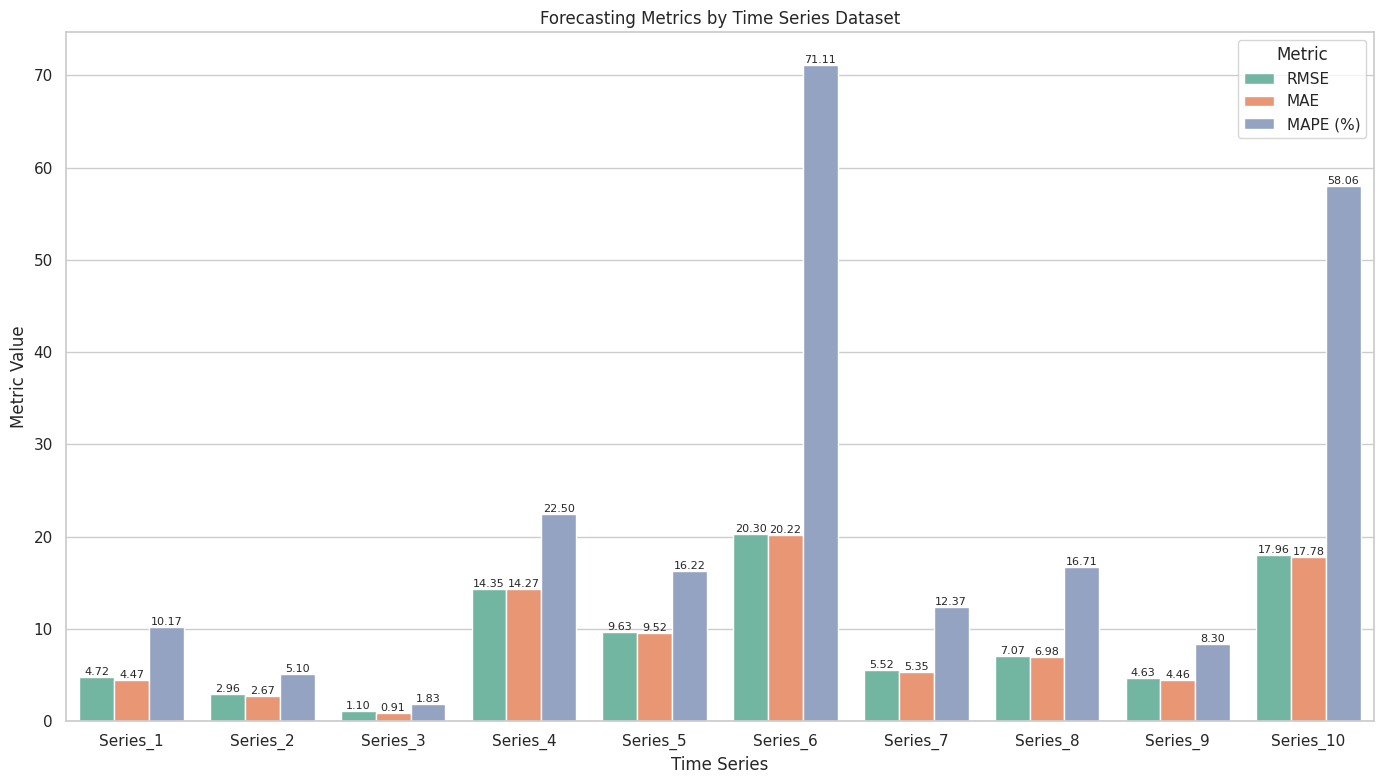

In [27]:
# Set plotting style
sns.set(style="whitegrid")

# Melt the metrics DataFrame
metrics_melted = metrics_df.melt(id_vars='Series', var_name='Metric', value_name='Value')

# Create grouped bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Series', y='Value', hue='Metric', data=metrics_melted, palette='Set2')
plt.title('Forecasting Metrics by Time Series Dataset')
plt.ylabel('Metric Value')
plt.xlabel('Time Series')
plt.legend(title='Metric')

# Annotate bar heights
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()

In [28]:
# Compute global metrics by averaging
global_rmse = metrics_df['RMSE'].mean()
global_mae = metrics_df['MAE'].mean()
global_mape = metrics_df['MAPE (%)'].mean()

# Create global metrics DataFrame
global_metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE (%)'],
    'Value': [global_rmse, global_mae, global_mape]
})

print("Global Metrics (Averaged Across All Series):")
display(global_metrics_df)

Global Metrics (Averaged Across All Series):


,Metric,Value
0,RMSE,8.824362
1,MAE,8.663369
2,MAPE (%),22.237219


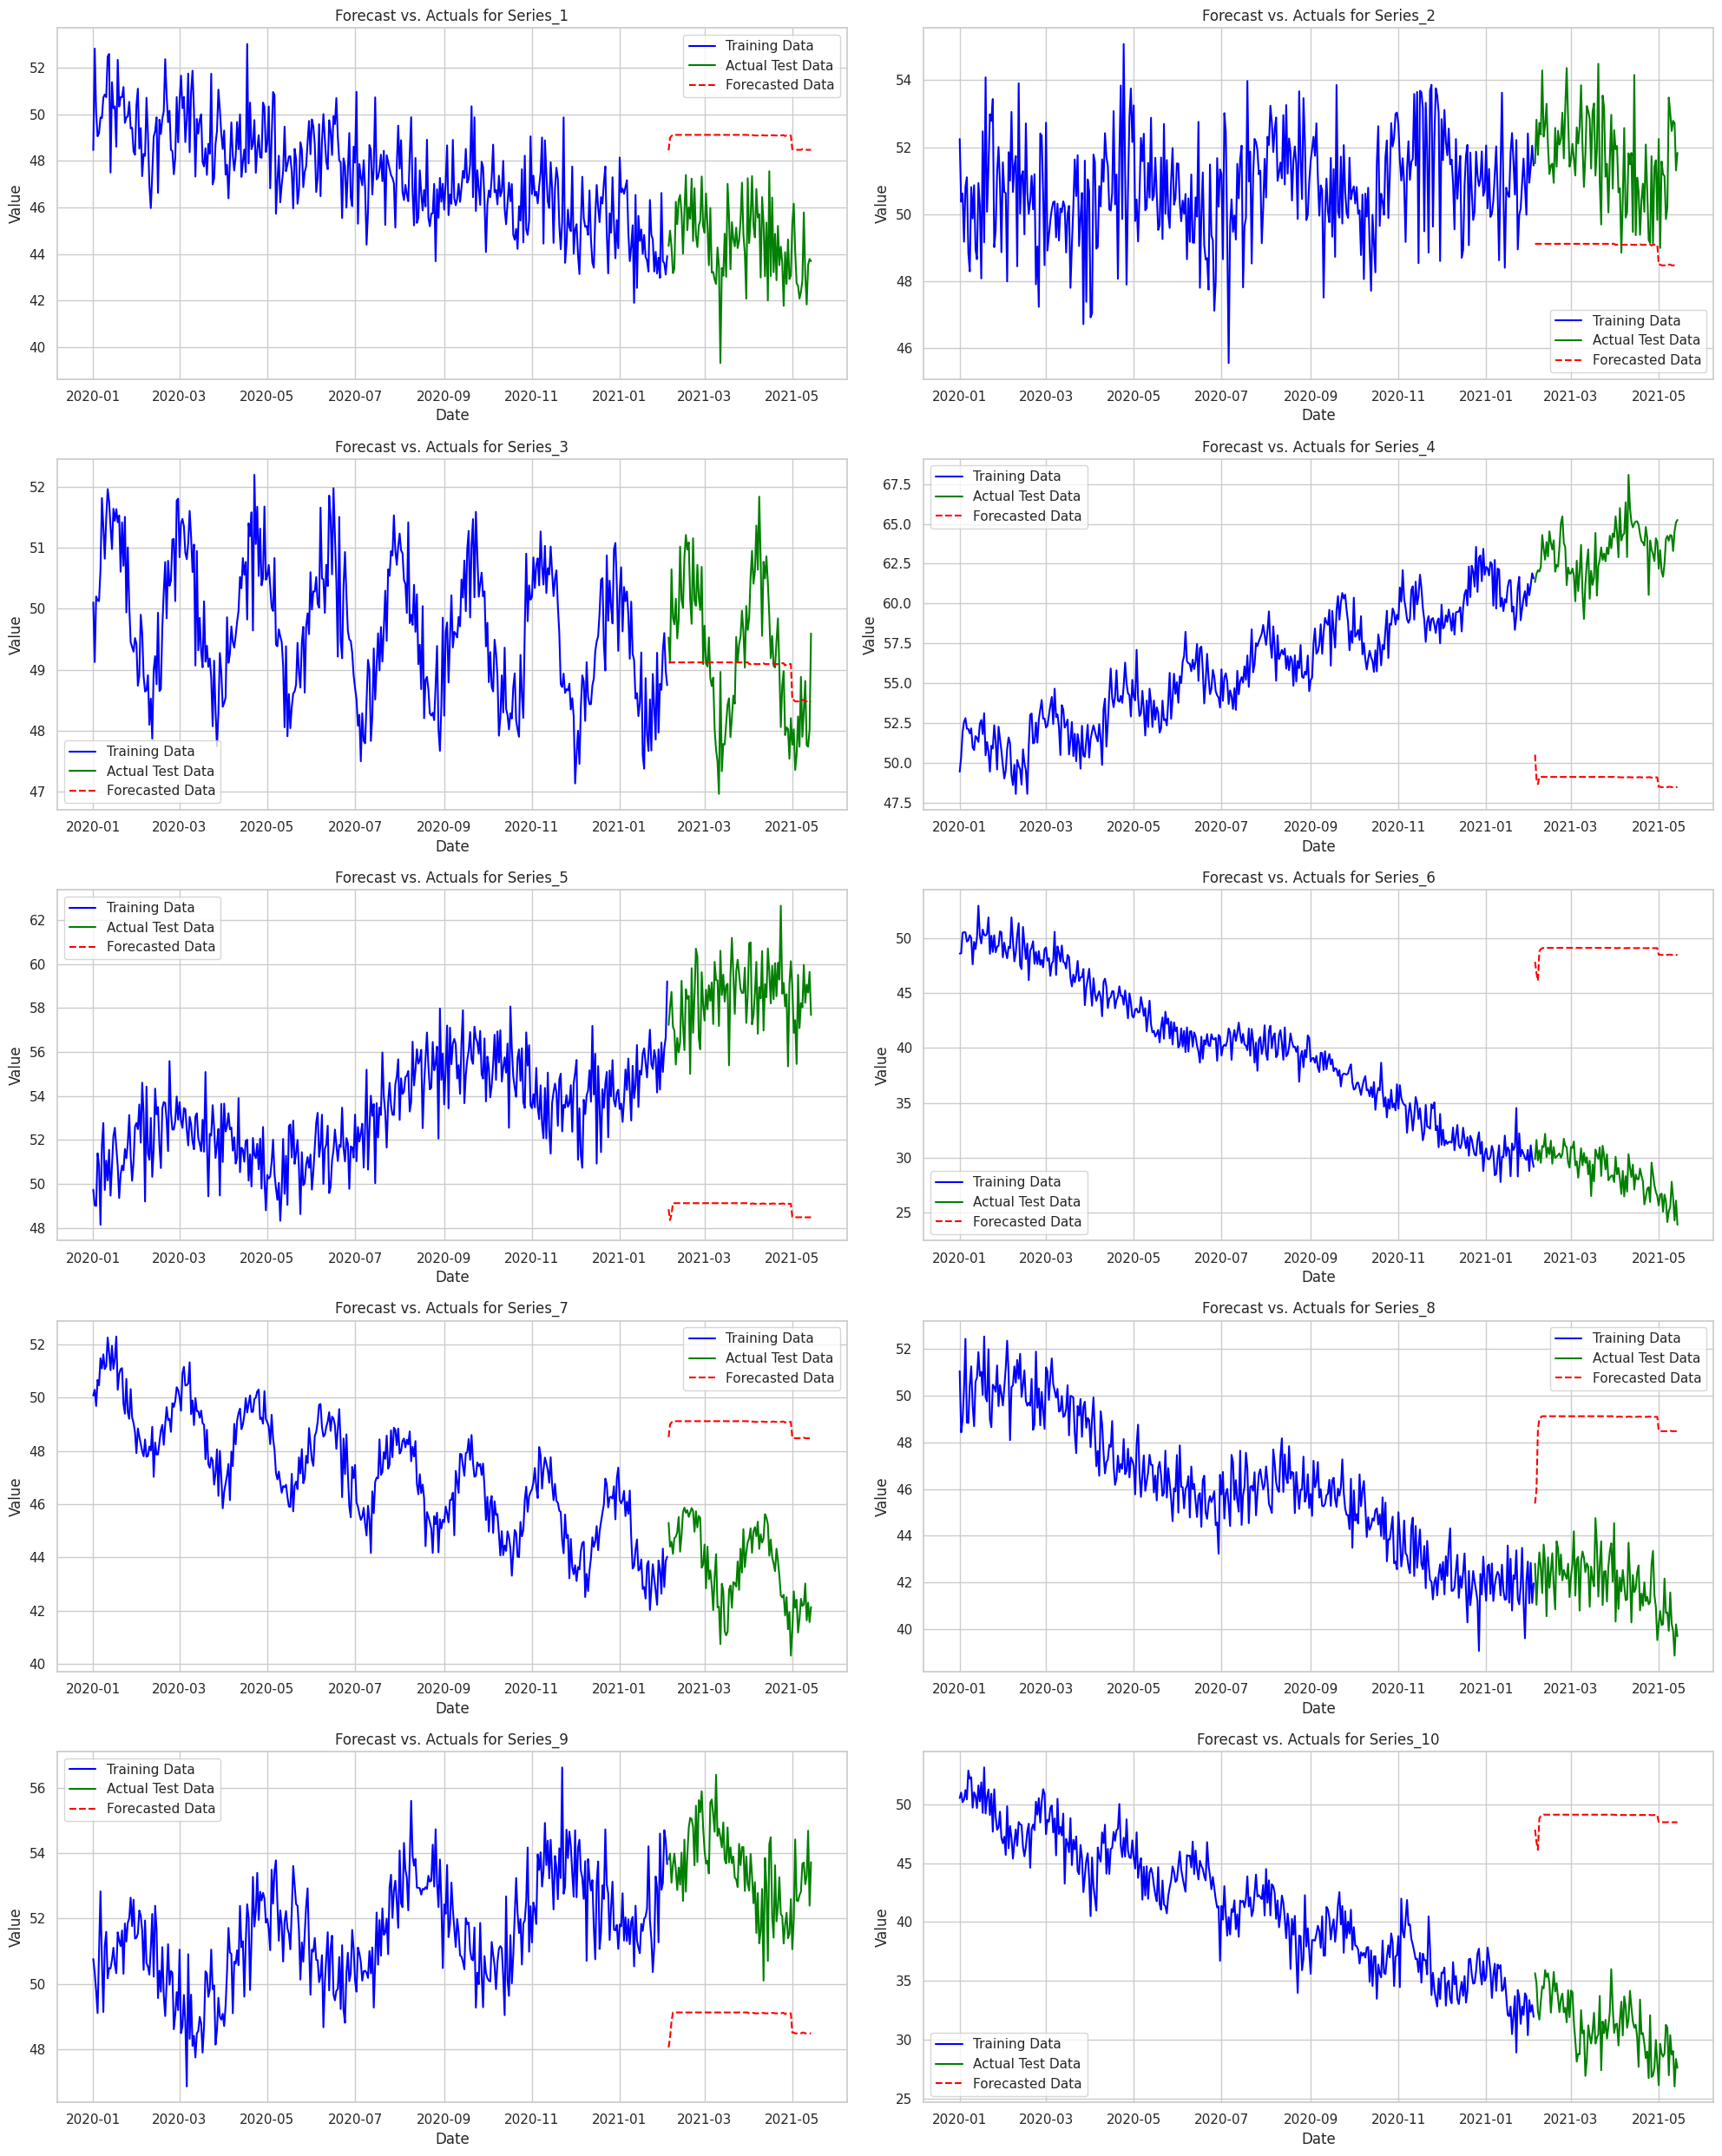

In [29]:
# Number of rows and columns for subplots
n_cols = 2
n_rows = int(np.ceil(n_series / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 25))
axes = axes.flatten()

for idx, series in enumerate(time_series_data.keys()):
    ax = axes[idx]

    # Training data
    ax.plot(df.index[:n_train], df[series].iloc[:n_train], label='Training Data', color='blue')

    # Actual test data
    ax.plot(df.index[n_train:], df[series].iloc[n_train:], label='Actual Test Data', color='green')

    # Forecasted data
    ax.plot(df.index[n_train:], forecasts[idx], label='Forecasted Data', color='red', linestyle='--')

    ax.set_title(f'Forecast vs. Actuals for {series}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

# Remove any unused subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [30]:
# Extract feature names
feature_names = X_train.columns.tolist()

# Extract feature importances
importances = best_model.named_steps['xgb'].feature_importances_

# Validation check: Feature importances
assert len(importances) == len(feature_names), "Mismatch between number of features and importances."

In [31]:
# Create DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
display(feature_importance_df)

Feature Importances:


,Feature,Importance
8,latent_1,0.227472
2,lag_3,0.225990
0,lag_1,0.178620
1,lag_2,0.163000
3,month,0.122465
9,latent_2,0.058657
7,quarter,0.023796
4,day,0.000000
5,day_of_week,0.000000
6,is_weekend,0.000000


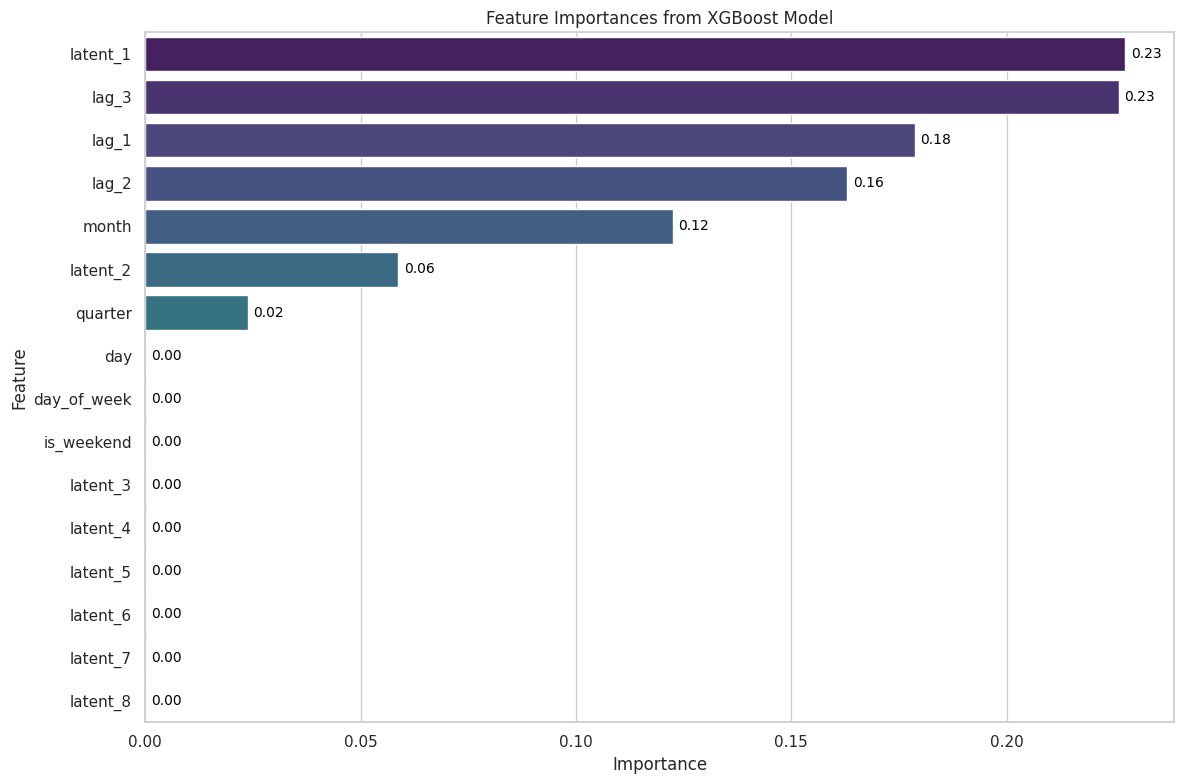

In [32]:
# Plot feature importances
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

# Add title and labels
plt.title('Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Add importance values to the end of the bars
for p in ax.patches:
    width = p.get_width()
    y_position = p.get_y() + p.get_height() / 2
    ax.text(
        width + max(feature_importance_df['Importance']) * 0.006,
        y_position,
        f'{width:.2f}',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

plt.tight_layout()
plt.show()